In [6]:
import pandas as pd

scores = pd.read_csv("Restaurant_Scores.csv")

print(len(scores.columns))
print(scores.columns)
#print(scores)

17
Index(['business_id', 'business_name', 'business_address', 'business_city',
       'business_state', 'business_postal_code', 'business_latitude',
       'business_longitude', 'business_location', 'business_phone_number',
       'inspection_id', 'inspection_date', 'inspection_score',
       'inspection_type', 'violation_id', 'violation_description',
       'risk_category'],
      dtype='object')


In [7]:
num_businesses = len(scores.business_id.unique())
num_inspections = len(scores.inspection_id.unique())

print("This data set contains", num_inspections, "inspections of", num_businesses, "businesses." )

This data set contains 9664 inspections of 2753 businesses.


In [8]:
#for now, drop rows with missing data
print('Original length:', len(scores))
scores = scores.dropna(subset=['inspection_score', 'business_latitude', 'business_longitude' ])
#for now, drop rows with 0 for lattitude (missing data)
#later, convert addresses to lat, long
scores = scores[scores.business_latitude > 37.7] #drop any point not in SF proper
scores = scores[scores.business_longitude < -122.375] #drop any point not in SF proper
print('New length:', len(scores))

Original length: 21158
New length: 16512


In [9]:
import numpy as np
scores_dedup = scores.groupby('inspection_id').mean()
score_change = []
for i in range(len(scores_dedup.index) - 1):
    if scores_dedup.business_id[i] == scores_dedup.business_id[i + 1]:
        score_diff = scores_dedup.inspection_score[i + 1] - scores_dedup.inspection_score[i]
        #grouping by inspection id and taking mean removed date - fix later
        #date_diff = scores_dedup.inspection_date[i + 1] - scores_dedup.inspection_date[i] 
        score_change.append([scores_dedup.inspection_score[i], score_diff])
score_change = np.array(score_change)

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
from numpy import linspace, meshgrid
# from matplotlib.mlab import griddata


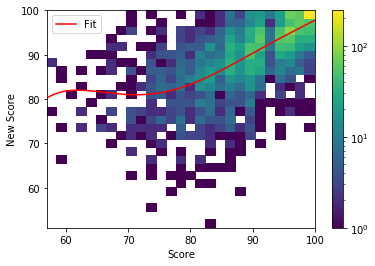

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import LogNorm

poly_model = make_pipeline(PolynomialFeatures(5),
                           LinearRegression())

poly_model.fit(score_change[:, 0, np.newaxis], score_change[:,1] + score_change[:, 0])

xfit = np.linspace(40, 100, 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

#plt.scatter(score_change[:,0], score_change[:,1])
plt.figure(figsize=(6,4))
plt.hist2d(score_change[:,0], score_change[:,1] + score_change[:, 0], bins=27, norm=LogNorm(), cmap='viridis')
plt.colorbar()
plt.xlabel("Score")
plt.ylabel("New Score")
regression_fit, = plt.plot(xfit, yfit, c='red', label='Fit')
plt.legend(handles=[regression_fit])

Testing Reinspections:

An interesting insight is that no matter how bad the previous score was, the next inspection score on average, is brought up into the low 80s (red line). If a health score of 80 is too low for your liking (it is for mine), there is a fairly linear relationship in the scores from around 85 to 100. Meaning, if a first score was good, it is likely to remain around the same value upon reinspection. That means if you really want a pristine experience (90-100), you may not even want to gamble on a decently scoring restaurant (~80).